# Part 1 - Data Analysing
## Chapter 5 - Fractionally Differentiated Features

In [1]:
import importlib

import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

### 5.1 Generate a time series from an IID Gaussian random process. This is a memoryless, stationary series:

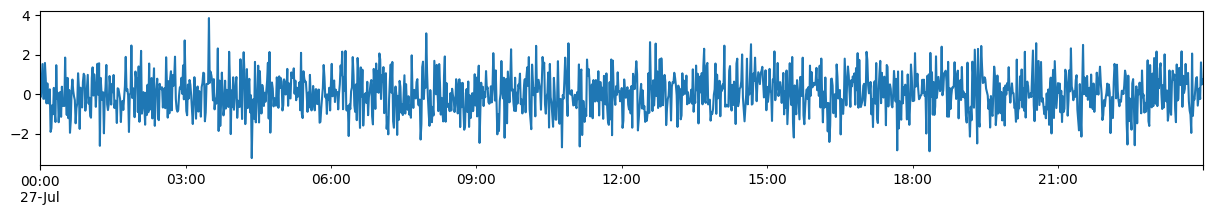

In [2]:
np.random.seed(42)

series = pd.Series(np.random.randn(24 * 60), index=pd.date_range("00:00:00", "23:59:00", freq="1min"))
series.plot(figsize=(15, 2))
None

#### 5.1 (a) Compute the ADF statistic on this series. What is the p-value?

In [3]:
_, p_value, *_  = adfuller(series)
print(f"ADF p value: {p_value}")

ADF p value: 0.0


#### 5.1 (b) Compute the cumulative sum of the observations. This is a non-stationary series without memory.

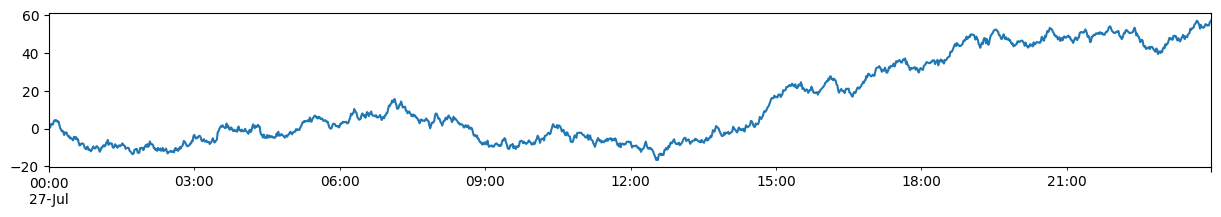

In [4]:
cum_series = series.cumsum()
cum_series.plot(figsize=(15, 2))
None

##### 5.1 (b) i. What is the order of integration of this cumulative series?
 > Order of Integration refers to the number of differencing operations needed to make a time series stationary
 The order integration is 1 because it will  take us back to the IId gaussian random process that we start with.
 
##### 5.1 (b) ii. Compute the ADF statistic on this series. What is the p-value?


In [5]:
for order in range(5):
    diff_ = np.diff(cum_series, order)
    _, p_value, *_  = adfuller(diff_)
    print(f"For order of difference {order} the ADF p value: {p_value}")
    if p_value < 0.05:
        print(f"Order Integration is {order}.")
        break

For order of difference 0 the ADF p value: 0.9742207677843584
For order of difference 1 the ADF p value: 0.0
Order Integration is 1.


#### 5.1 (c) Differentiate the series twice. What is the p-value of this over-differentiated series?

In [6]:
diff_ = np.diff(cum_series, 2)
_, p_value, *_  = adfuller(diff_)
print(f"For order of difference 2 the ADF p value: {p_value}")

For order of difference 2 the ADF p value: 5.035754538048873e-24


### 5.2 Generate a time series that follows a sinusoidal function. This is a stationary series with memory.

<Axes: >

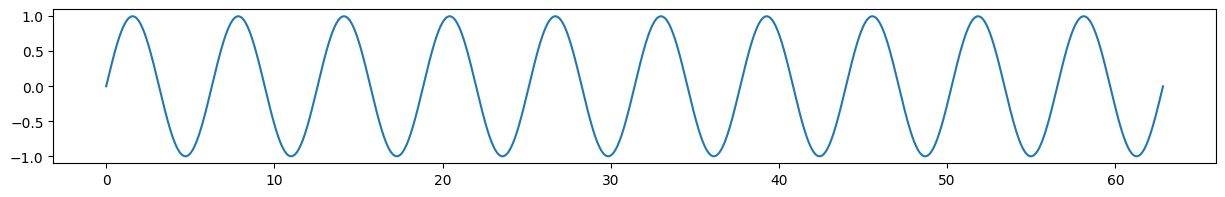

In [7]:
x = np.linspace(0, 20 * np.pi, 5_000)
series = pd.Series(np.sin(x), dtype = float, index=x)
series.plot(figsize=(15, 2))

#### 5.2 (a) Compute the ADF statistic on this series. What is the p-value?

In [8]:
_, p_value, *_  = adfuller(series)
print(f"ADF p value: {p_value}")

ADF p value: 0.0


#### 5.2 (b) Shift every observation by the same positive value. Compute the cumulative sum of the observations. This is a non-stationary series with memory.

<Axes: >

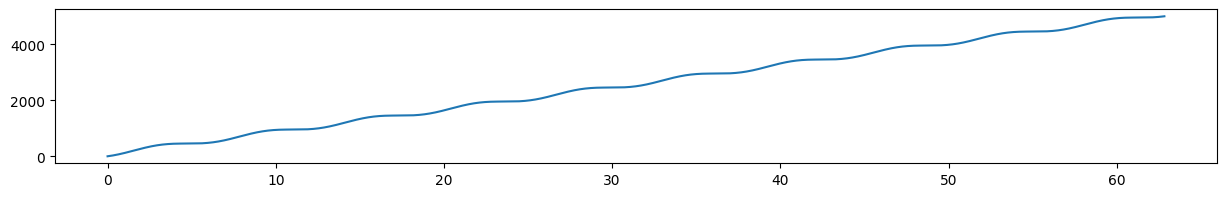

In [9]:
shift = 1
series = pd.Series(np.sin(x)+shift, dtype = float, index=x)
cum_series = series.cumsum()
cum_series.plot(figsize=(15, 2))

##### 5.2 (b) i. Compute the ADF statistic on this series. What is the p-value?

In [10]:
_, p_value, *_  = adfuller(cum_series)
print(f"ADF p value: {p_value}")

ADF p value: 1.0


##### 5.2 (b) ii. Apply an expanding window fracdiff, with $\tau$ = 1E − 2. For what minimum d value do you get a p-value below 5%?

In [11]:
from utils.fractionally_differentiated_features import frac_diff_expanding_window

for d in np.linspace(0, 2, 101):
    differentiated_series_df = frac_diff_expanding_window(pd.DataFrame(cum_series), d, tau=1e-2)
    adf_result = adfuller(differentiated_series_df.dropna().values.squeeze())
    if adf_result[1] < 0.05:
        print(f'Minimum d with p-value < 5%: {d}')
        break

Minimum d with p-value < 5%: 0.02


##### 5.2 (b) iii. Apply FFD, with $\tau$ = 1E−5. For what minimum d value do you get a p-value below 5%?

In [12]:
from utils.fractionally_differentiated_features import frac_diff_ffd

for d in np.linspace(0, 2, 101):
    differentiated_series_df = frac_diff_ffd(pd.DataFrame(cum_series), d, tau=1e-5)
    adf_result = adfuller(differentiated_series_df.dropna().values.squeeze())
    if adf_result[1] < 0.05:
        print(f'Minimum d with p-value < 5%: {d}')
        break

Minimum d with p-value < 5%: 1.0


### 5.3 Take the series from exercise 5.2 (b):
#### Fit the series to a sine function. What is the R-squared?

R-squared for cumulative series: 0.0027007855608441877


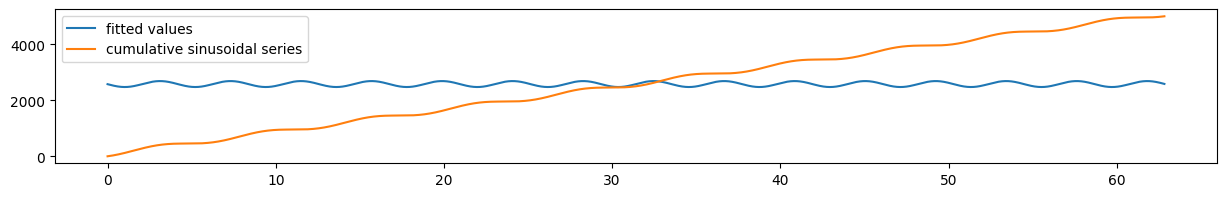

In [13]:
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Define the sine function to fit
def sine_function(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(frequency * x + phase) + offset

params, _ = curve_fit(sine_function, x, cum_series)     # type: ignore
fitted_values = sine_function(x, *params)
plt.figure(figsize=(15, 2))
plt.plot(x, fitted_values, label='fitted values')
plt.plot(x, cum_series, label='cumulative sinusoidal series')
plt.legend(loc='best')
r_squared_original = r2_score(cum_series, fitted_values)

print(f'R-squared for cumulative series: {r_squared_original}')


#### 5.3 (b) Apply FFD(d=1). Fit the series to a sine function. What is the R-squared?

R-squared for cumulative series: 0.9999999999999998


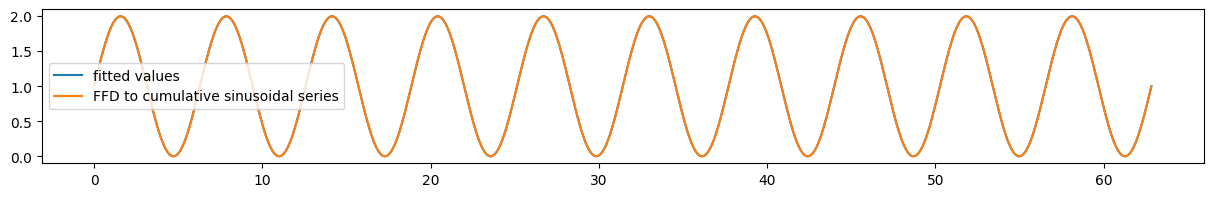

In [14]:
res = frac_diff_ffd(pd.DataFrame({'cum_series': cum_series}), d=1, tau=1e-5)
ffd_res = res['cum_series'].values
ffd_x = x[-len(ffd_res):]

params, _ = curve_fit(sine_function, ffd_x, ffd_res)
fitted_values = sine_function(ffd_x, *params)
plt.figure(figsize=(15, 2))
plt.plot(ffd_x, fitted_values, label='fitted values')
plt.plot(ffd_x, ffd_res, label='FFD to cumulative sinusoidal series')
plt.legend(loc='best')


r_squared_original = r2_score(ffd_res, fitted_values)
print(f'R-squared for cumulative series: {r_squared_original}')

#### 5.3 (c) What value of d maximizes the R-squared of a sinusoidal fit on FFD(d). Why?

Max R-squared for cumulative series with FFD(d=2.0) = 1.0


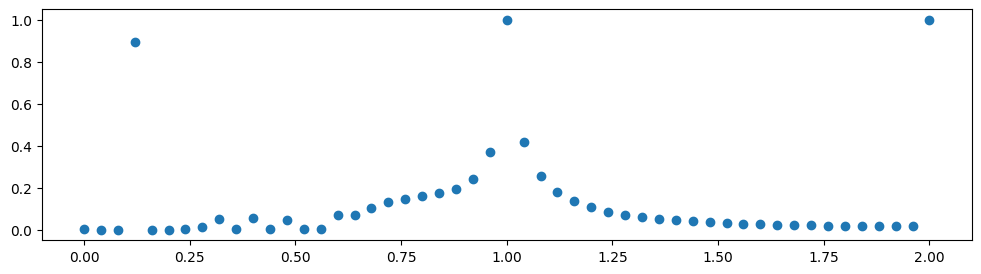

In [15]:
from utils.fractionally_differentiated_features import frac_diff_ffd

r_squares = []
d_domain = np.linspace(0, 2, 51)
for d in d_domain:
    res = frac_diff_ffd(pd.DataFrame({'cum_series': cum_series}), d=d, tau=1e-5)
    ffd_res = res['cum_series'].values
    ffd_x = x[-len(ffd_res):]
    
    params, _ = curve_fit(sine_function, ffd_x, ffd_res)
    fitted_values = sine_function(ffd_x, *params)
    r_squared_original = r2_score(ffd_res, fitted_values)
    r_squares.append(r_squared_original)

print(f'Max R-squared for cumulative series with FFD(d={d_domain[np.argmax(r_squares)]}) = {np.max(r_squares)}')
plt.figure(figsize=(12, 3))
plt.scatter(d_domain, r_squares)

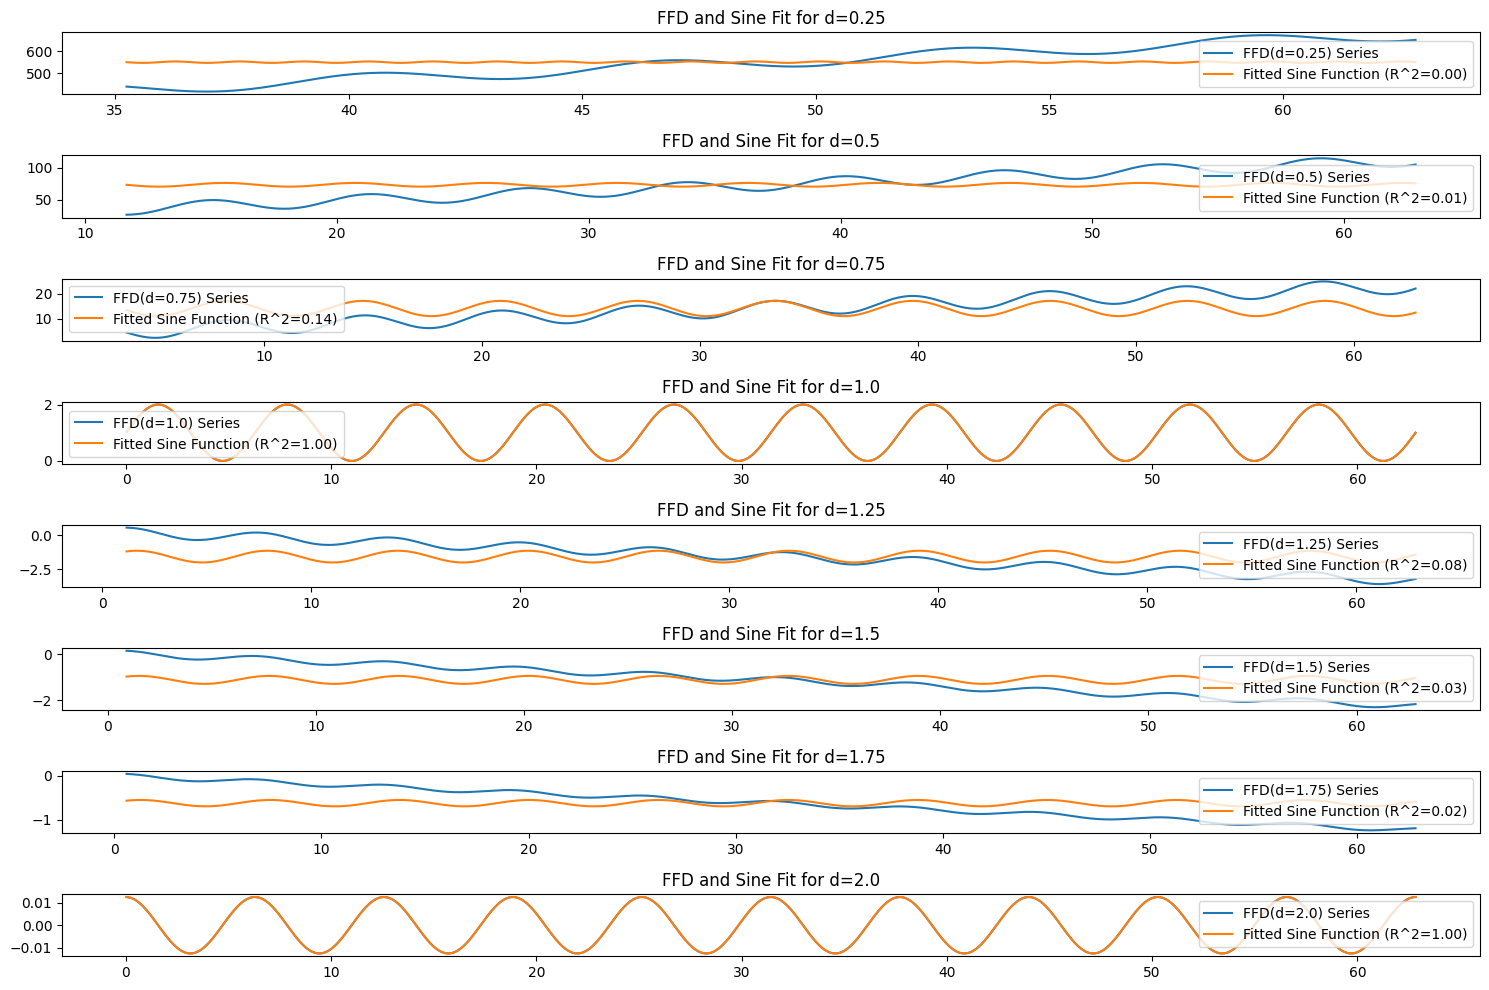

In [16]:
import matplotlib.pyplot as plt

def visualize_ffd_and_fit(d_values, original_series):
    plt.figure(figsize=(15, 10))

    for d in d_values:
        ffd_series = frac_diff_ffd(pd.DataFrame({'original_series': original_series}), d, tau=1e-5)
        ffd_series = ffd_series['original_series'].dropna().values
        x_values = x[-len(ffd_series):]

        params_ffd, _ = curve_fit(sine_function, x_values, ffd_series)
        fitted_values_ffd = sine_function(x_values, *params_ffd)
        r_squared_ffd = r2_score(ffd_series, fitted_values_ffd)
        
        plt.subplot(len(d_values), 1, d_values.index(d) + 1)
        plt.plot(x_values, ffd_series, label=f'FFD(d={d}) Series')
        plt.plot(x_values, fitted_values_ffd, label=f'Fitted Sine Function (R^2={r_squared_ffd:.2f})')
        plt.legend()
        plt.title(f'FFD and Sine Fit for d={d}')

    plt.tight_layout()
    plt.show()

# Apply visualization
d_values_to_visualize = list(np.arange(0.25, 2.01, 0.25))
visualize_ffd_and_fit(d_values_to_visualize, cum_series)


### 5.4 Take the dollar bar series on E-mini S&P 500 futures. Using the code in Snippet 5.3, for some d ∈ [0, 2], compute fracDiff_FFD(fracDiff_FFD(series,d),-d). What do you get? Why?

In [17]:
from utils.bars_generator import create_dollar_bars__rolling
from utils import general

btc_dollar = general.load_transactions_and_generate("data\BTCUSDT-trades-2024-*.parquet", create_dollar_bars__rolling, T=int(1e8))

100%|██████████| 5/5 [01:16<00:00, 15.38s/it]


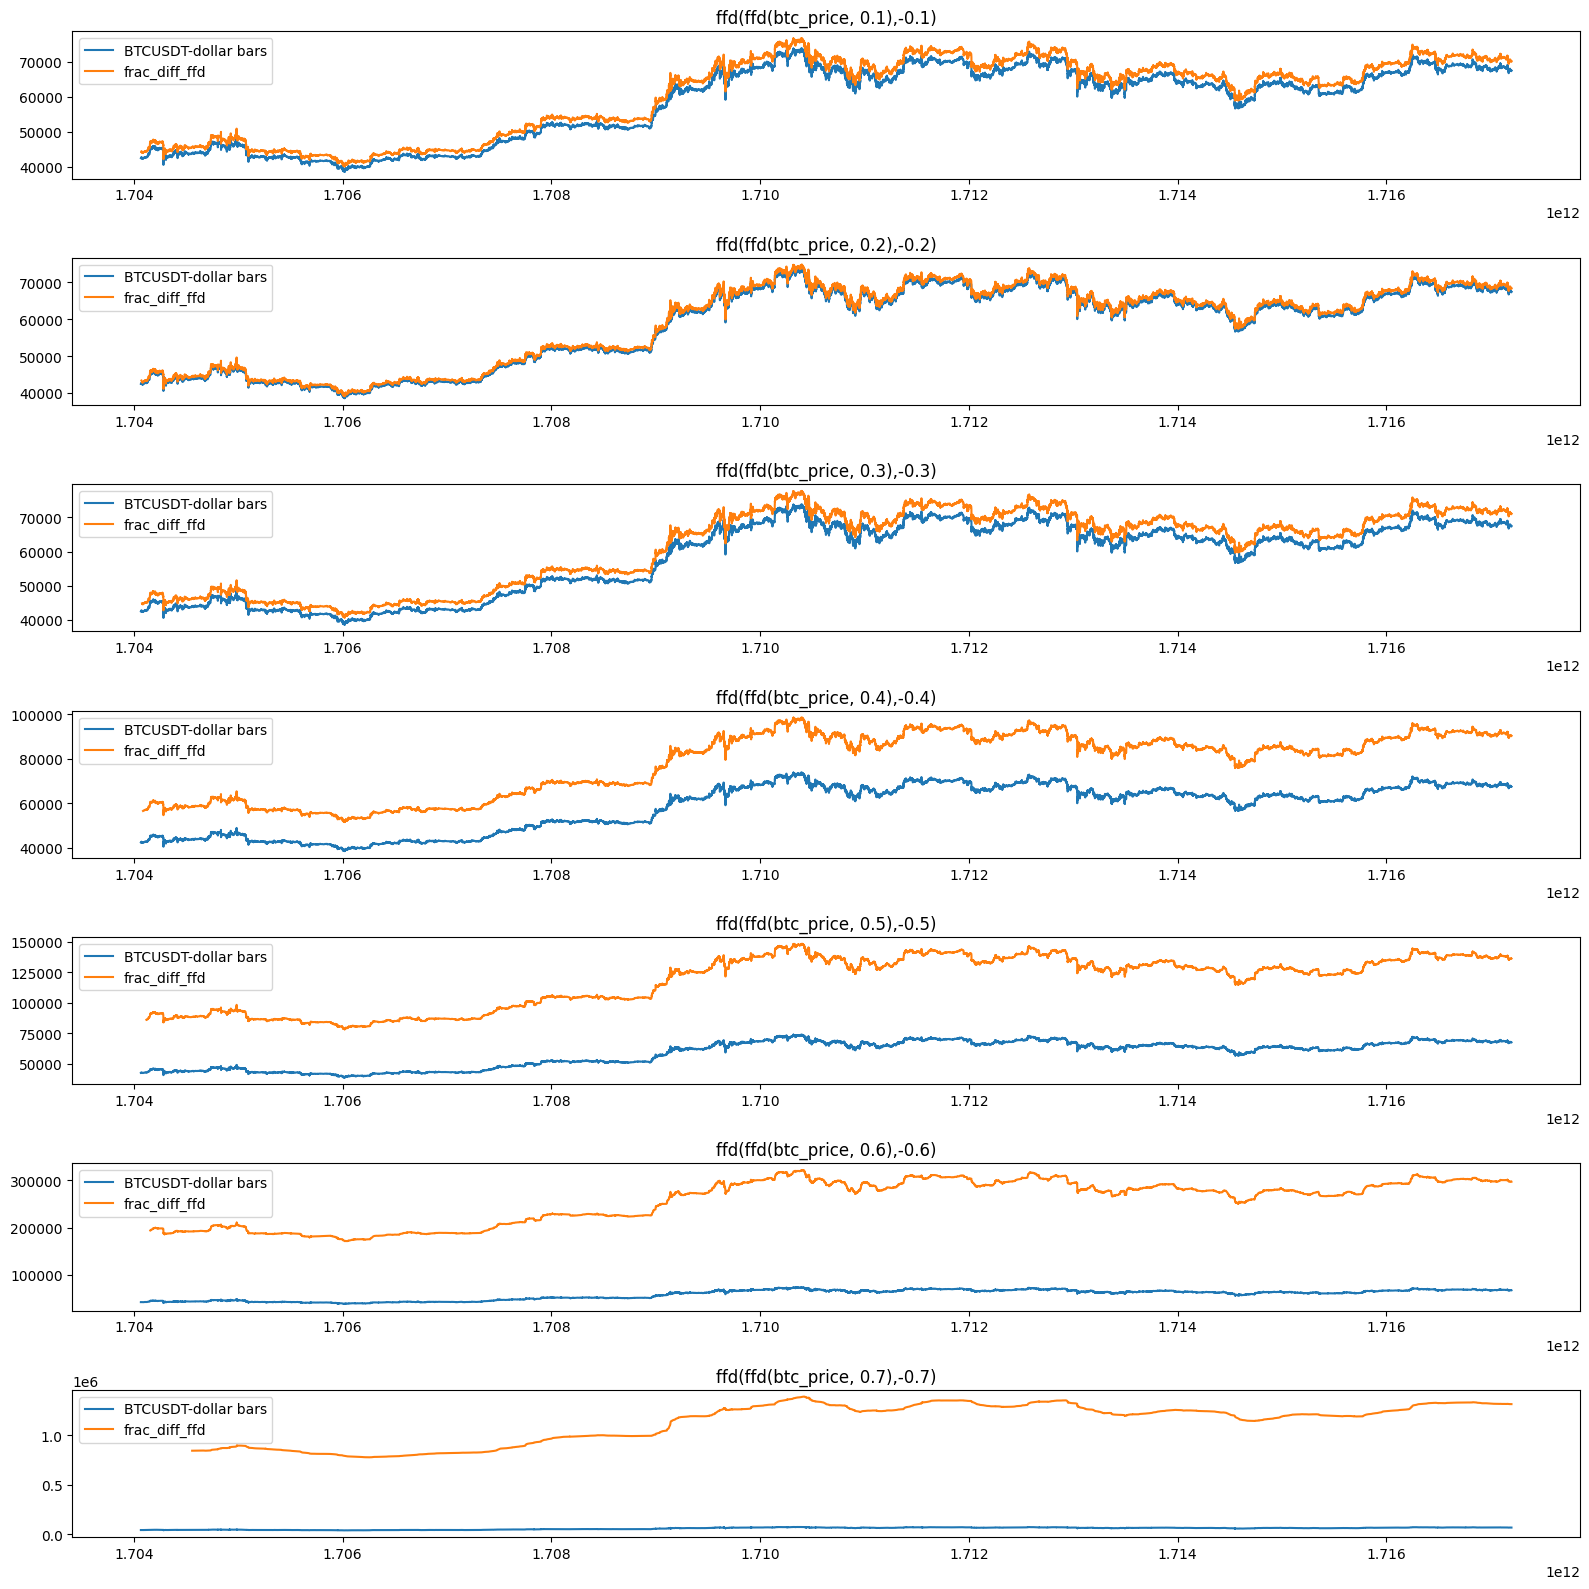

In [59]:
import importlib
from utils import fractionally_differentiated_features
importlib.reload(fractionally_differentiated_features)
from utils.fractionally_differentiated_features import frac_diff_ffd, get_weights_ffd

d_domains =  np.arange(0.1, 0.8, 0.1)
fig, axes = plt.subplots(len(d_domains), 1, figsize=(16, 16))
for ax, d in zip(axes, d_domains):
    res = frac_diff_ffd(frac_diff_ffd(btc_dollar[['close']], d, tau=0.1), -d, tau=0.1)
    ax.plot(btc_dollar['close'], label='BTCUSDT-dollar bars')
    ax.plot(res, label='frac_diff_ffd')
    ax.set_title(f'ffd(ffd(btc_price, {d:.1f}),-{d:.1f})')
    ax.legend()

plt.tight_layout()
plt.show()


Because we take ffd(ffd(series, d), -d), and we requested do use d ∈ [0, 2]
When d < 1 the weights are decreasing, on cases where 0.7 < d < 1 the decrease if of the weights is very slow and may cause memory error.
When d == 1 the weights are constant 1 so it actually the sum of the weights.
When d > 1 the weights are growing makes the older the price the heavier weight it gets.

I show on these plots only when d ∈ [0, 0.7], the smaller d the "better" reconstructions, even though ffd^-1(d) != ffd(-d).


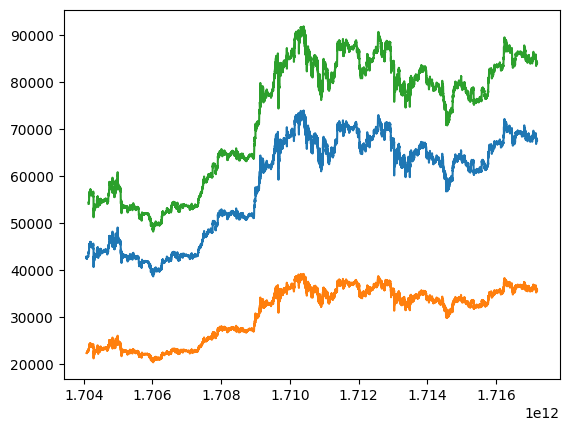

In [63]:
f1 = frac_diff_ffd(btc_dollar[['close']], 0.2, tau=0.01)
plt.plot(btc_dollar[['close']])
plt.plot(f1)
plt.plot(frac_diff_ffd(f1, -0.2, tau=0.01))

In [58]:
def get_weights_ffd_(d, tau):
    w = [1.]
    k = 1
    while abs(w[-1]) >= tau:
        w_ = -w[-1] / k * (d - k + 1)
        w.append(w_)
        k += 1
        if k == 1000:
            break
    return np.array(w[::-1])

print(get_weights_ffd_(-0.8, 0.05))

[0.21578112 0.21582433 0.21586759 0.2159109  0.21595427 0.21599768
 0.21604115 0.21608467 0.21612825 0.21617188 0.21621556 0.21625929
 0.21630307 0.21634691 0.21639081 0.21643475 0.21647875 0.21652281
 0.21656691 0.21661107 0.21665529 0.21669956 0.21674388 0.21678826
 0.21683269 0.21687718 0.21692172 0.21696632 0.21701097 0.21705568
 0.21710045 0.21714526 0.21719014 0.21723507 0.21728005 0.21732509
 0.21737019 0.21741535 0.21746056 0.21750582 0.21755115 0.21759653
 0.21764196 0.21768746 0.21773301 0.21777861 0.21782428 0.21787
 0.21791578 0.21796162 0.21800752 0.21805347 0.21809949 0.21814556
 0.21819169 0.21823787 0.21828412 0.21833043 0.21837679 0.21842321
 0.2184697  0.21851624 0.21856284 0.2186095  0.21865622 0.21870301
 0.21874985 0.21879675 0.21884371 0.21889073 0.21893782 0.21898496
 0.21903217 0.21907943 0.21912676 0.21917415 0.2192216  0.21926911
 0.21931669 0.21936432 0.21941202 0.21945978 0.2195076  0.21955549
 0.21960344 0.21965145 0.21969952 0.21974766 0.21979586 0.2198441